- Hyperparameter Tuning
- mixed precision tests

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.keras.__version__)
print(tf.__version__)
tf.config.list_physical_devices('GPU')
#keras.mixed_precision.set_global_policy("mixed_float16") # turn on mixed precision for faster computation

2.12.0
2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'
#train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/train_set'
#test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/val_set'

In [3]:
import random

def load_data(train_img_dir, test_img_dir, image_size=(224,224), batch_size=32, validation_split=0.2):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=validation_split,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [5]:
import numpy as np

classes = {0: 'neutral', 
           1: 'happiness', 
           2: 'sadness', 
           3: 'surprise', 
           4: 'fear', 
           5: 'disgust', 
           6: 'anger', 
           7: 'contempt'}

# calculate weights on class distribution from 0-7
total_images = 287_652
images_per_class = [74_874, 134_415, 25_459, 14_090, 6_378, 3_803, 24_882, 3_750]
class_distribution = [d/total_images for d in images_per_class]
# inverse class distribution for weights (lower dist = higher weight)
class_weights = [1.0 / dist for dist in class_distribution]
# normalize
class_weights_normalized = class_weights / np.sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_normalized)}
class_weights_dict

{0: 0.01557266066902349,
 1: 0.008674533310511956,
 2: 0.045798632897304084,
 3: 0.08275283143594497,
 4: 0.18281395342308948,
 5: 0.3065967380837404,
 6: 0.04686067819839501,
 7: 0.31092997198199057}

---

In [23]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace
import keras_tuner

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # Load Base Model
        vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
        vgg_model.trainable = True
        for layer in vgg_model.layers[:-33]: # starting with res5
            layer.trainable = False
        
        inputs = keras.Input(shape=(224, 224, 3))
        x = data_augmentation(inputs)
        x = keras.applications.resnet.preprocess_input(x)
        x = vgg_model(x)
        x = layers.Flatten(name='flatten')(x)
        # Test dense units
        x = layers.Dense(units=hp.Choice("units", [1024, 2048, 4096]), activation="relu")(x)
        outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x)
        return keras.Model(inputs, outputs)
    
    def fit(self, hp, model, train_img_dir, test_img_dir, callbacks=None, **kwargs):
        # Test batch size
        batch_size = hp.Int("batch_size", 32, 128, step=32, default=64)
        (train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir, batch_size=batch_size)
        
        # Define optimizer, test learning rate
        optimizer = keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-8, 1e-2, sampling="log", default=1e-3)
        )
        loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Metric to track val loss (mean of all batches per epoch)
        epoch_loss_metric = keras.metrics.Mean()
        
        # Run train step
        @tf.function
        def run_train_step(images, labels):
            with tf.GradientTape() as tape:
                logits = model(images)
                loss = loss_fn(labels, logits)
                # Add any regularization losses.
                if model.losses:
                    loss += tf.math.add_n(model.losses)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Function to run the validation step.
        @tf.function
        def run_val_step(images, labels):
            logits = model(images)
            loss = loss_fn(labels, logits)
            # Update the metric.
            epoch_loss_metric.update_state(loss)

        # Assign the model to the callbacks.
        for callback in callbacks:
            callback.model = model

        # Record the best validation loss value
        best_epoch_loss = float("inf")
        
        # The custom training loop.
        for epoch in range(25):
            print(f"Epoch: {epoch}")

            # Iterate the training data to run the training step.
            for images, labels in train_dataset:
                run_train_step(images, labels)

            # Iterate the validation data to run the validation step.
            for images, labels in val_dataset:
                run_val_step(images, labels)

            # Calling the callbacks after epoch.
            epoch_loss = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner.
                callback.on_epoch_end(epoch, logs={"val_loss": epoch_loss})
            epoch_loss_metric.reset_states()

            print(f"Epoch loss: {epoch_loss}")
            best_epoch_loss = min(best_epoch_loss, epoch_loss)

        # Return the evaluation metric value.
        return best_epoch_loss

In [24]:
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("val_loss", "min"),
    max_trials=2,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)

tuner.search(train_img_dir, test_img_dir)

Trial 2 Complete [01h 47m 01s]
val_loss: 0.8430920243263245

Best val_loss So Far: 0.7732552886009216
Total elapsed time: 03h 36m 51s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'units': 2048, 'batch_size': 64, 'learning_rate': 0.001}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 fl

In [26]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir, batch_size=32)
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
125/125 [==============================] - 5s 34ms/step - loss: 1.7427 - accuracy: 0.4259
Test accuracy: 0.426


---

In [7]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace
import keras_tuner

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_vggface-resnet50_finetuned_"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name + 'e{epoch:02d}-vloss{val_loss:.2f}.keras',
        save_best_only=True,
        #save_freq='epoch',
        monitor="val_loss",
        verbose=0),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=20),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-8)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230714_21-50_fer_vggface-resnet50_finetuned_
Epoch 1/50
7192/7192 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.4915
Epoch 1: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E01-VLoss1.07.keras
7192/7192 [==============================] - 540s 74ms/step - loss: 0.0491 - accuracy: 0.4915 - val_loss: 1.0703 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 2/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.5349
Epoch 2: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E02-VLoss0.96.keras
7192/7192 [==============================] - 528s 73ms/step - loss: 0.0435 - accuracy: 0.5349 - val_loss: 0.9631 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 3/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.5450
Epoch 3: sa

Epoch 24/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.5986
Epoch 24: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E24-VLoss0.97.keras
7192/7192 [==============================] - 528s 73ms/step - loss: 0.0340 - accuracy: 0.5986 - val_loss: 0.9665 - val_accuracy: 0.6190 - lr: 8.0000e-06
Epoch 25/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.5978
Epoch 25: saving model to 20230714_21-50_fer_vggface-resnet50_finetuned_E25-VLoss0.97.keras

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
7192/7192 [==============================] - 527s 73ms/step - loss: 0.0339 - accuracy: 0.5978 - val_loss: 0.9672 - val_accuracy: 0.6186 - lr: 8.0000e-06


In [8]:
model = history.model
#print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 6s 44ms/step - loss: 1.1821 - accuracy: 0.5889
Test accuracy: 0.589


---

## #1 Best Model so far

In [25]:
model = keras.models.load_model('20230714_21-50_fer_vggface-resnet50_finetuned_E16-VLoss0.99.keras')
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_21-50_fer_vggface-resnet50_finetuned_
125/125 [==============================] - 5s 40ms/step - loss: 1.1595 - accuracy: 0.5926
Test accuracy: 0.593


---

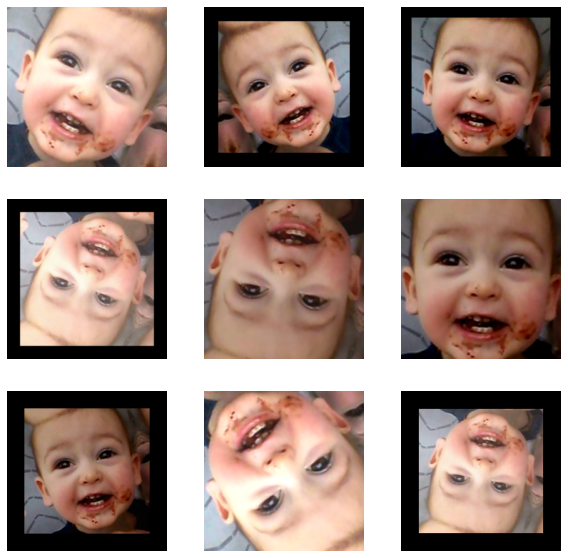

In [32]:
# Check Data Augmentation Layers
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

#(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

fig = plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

---